In [1]:
!git clone https://github.com/arthurbabu/IA_sound_localization.git

Cloning into 'IA_sound_localization'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 1), reused 16 (delta 1), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
!pip install pyroomacoustics

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.6.0-cp37-cp37m-linux_x86_64.whl size=9767539 sha256=1f9180fbdc7a86e718b6ffa085cc71577985988e7618caaaf472684ad1cb901c
  Stored in directory: /root/.cache/pip/wheels/4f/4b/d9/089980483d6e617e61fceb2a0a94760d7beabc445bf0de761e
Successfully built pyroomacoustics


# Localisation sonore

## Introduction

Le cerveau humain est capable grâce aux informations venant du système auditif de déterminer la direction et la distance approximative d'une onde sonore. En se plaçant en coordonnées sphériques ayant pour centre la tête, l'origine d'un son est déterminée par 3 paramètres : l'azimuth (angle sur le plan horizontal), l'élévation (angle sur le plan vertical) et la distance.  Pour un être humain, la précision en azimuth est de 8,5° autour de la vraie position. Cependant, repérer l'élévation et la distance d'un son est plus difficile [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6219530/). Plusieurs indices sont utilisés par le cerveau afin de déduire l'origine d'un son. Tout d'abord, le décalage de l'onde sonore entre les deux oreilles permet la détermination de l'azimuth. La perte d'amplitude du signal permet d'estimer la distance. Enfin, de nombreux autres phénomènes plus complexes sont pris en compte comme le traitement de l'onde transmise par la tête d'une oreille à l'autre (fonction de transfert de la tête) ou bien l'atténuation différentes des fréquences en fonction de la distance [[2]](https://en.wikipedia.org/wiki/Sound_localization). 

![Axes localisation](/content/IA_sound_localization/img/localisation_axis.jpg)

## Etat de l'art


Des systèmes de visio-conférence intelligents existent déjà [[3]](https://www.poly.com/fr/fr/innovations/smart-camera-technology). Cependant, cela fonctionne par triangulation et corrélation de signal et nécessite une calibration ainsi que la présence de plusieurs micros à des endroits différents.

Une étude a été menée en utilisant un réseau de neurones profond à convolution [[4]](https://www.researchgate.net/publication/316698525_Sound_Source_Localization_Using_Deep_Learning_Models). Le nombre d'examples utilisés est de 2,43 millions. Pour entrainer leur modèle sur 70 exemples, une epoch met 24 h en utilisant un GPU NVIDIA Titan X.

## Objectifs

Le premier objectif est de constituer un dataset de taille suffisante, idéalement dans différents environnements. Pour cela, une première idée est d'utiliser les caméras de motion capture présentes sur le campus et de déplacer une source sonore (dont la composition spectrale varie en fonction du temps). Ainsi, cela fourni 3 fichiers intéressants : la position de la source sonore, la position du récepteur et l'audio reçu par le récepteur (voir avec Renaud Séguier si cela est faisable). Dans un second temps, le premier objectif sera d'implémenter un algorithme d'IA afin de déterminer la position de la source sonore par rapport au récepteur (selon l'axe d'azimuth) puis ajouter la notion de distance et d'élévation. Il sera intéressant de voir à quel point l'algorithme sera robuste à un changement d'environnement sonore et de type de sons émis.

Voici un premier graphique décrivant l'architecture de l'algorithme :

![Archi v1](/content/IA_sound_localization/img/arch_v1.png)

Direction of arrival

## Références


[[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6219530/) Accuracy-Precision Trade-off in Human Sound Localisation

[[2]](https://en.wikipedia.org/wiki/Sound_localization) Sound localization

[[3]](https://www.poly.com/fr/fr/innovations/smart-camera-technology) Caméra de visio-conférence

[[4]](https://www.researchgate.net/publication/316698525_Sound_Source_Localization_Using_Deep_Learning_Models) Réseaux de neurones pour la localisation sonore

[[5]](https://github.com/sharathadavanne/seld-net) Datasets


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Compute on GPU if available
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device_gpu = torch.device(dev)

In [5]:
# Import sound files
files = ["/content/IA_sound_localization/sounds/riff_1.wav",
         "/content/IA_sound_localization/sounds/riff_2.wav",
         "/content/IA_sound_localization/sounds/riff_3.wav",
         "/content/IA_sound_localization/sounds/riff_4.wav"]

signals = []
fs = 0

for file in files:
    fs, signal = wavfile.read(file)
    res = []
    for i in range(len(signal)):
      res.append(signal[i][0])
    signal = res
    signals.append(signal[0:int(fs)])


# PARAMETERS

SOUND_FILE_SIZE = int(fs) # Use only 1 second
BATCH_SIZE = 32  # Must be 32 if running on CPU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # This is added back by InteractiveShellApp.init_path()


# First implementation

## Sound propagation computation

Generate output files with target azimuth sound source.


---



In [6]:
# Sound generation with pyroomacoustics raytracing
# Generate microphones signal with target azimuth source

def generateSound3D(azimuth, fileSize):

    # Generate a 20x20x20 meters room
    corners = np.array([[0,0], [0,20], [20,20], [20,0]]).T  # [x,y]
    room = pra.Room.from_corners(corners, fs=fs, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
    room.extrude(20., materials=pra.Material(0.2, 0.15))

    # Set the ray tracing parameters
    room.set_ray_tracing(receiver_radius=0.2, n_rays=100000, energy_thres=1e-5)

    # add source and set the signal to WAV file content
    distance = random.uniform(1,9)
    elevation = random.uniform(1,19)
    elevation_offset = random.uniform(-0.5,0.5)
    
    x_s = 10 + np.cos(azimuth)*distance
    y_s = 10 + np.sin(azimuth)*distance
    z_s = elevation + elevation_offset
    
    room.add_source([x_s, y_s, z_s], signal=random.choice(signals))

    # add two-microphone array
    room.add_microphone(loc=[10 + np.cos(0), 10 + np.sin(0), 10])
    room.add_microphone(loc=[10 + np.cos(np.pi/2), 10 + np.sin(np.pi/2), 10])
    room.add_microphone(loc=[10 + np.cos(np.pi), 10 + np.sin(np.pi), 10])
    room.add_microphone(loc=[10 + np.cos(3*np.pi/2), 10 + np.sin(3*np.pi/2), 10])

    # compute image sources
    room.image_source_model()

    # generate files
    room.simulate()

    # return files
    mic1 = room.mic_array.signals[0,:][:fileSize]
    mic2 = room.mic_array.signals[1,:][:fileSize]
    mic3 = room.mic_array.signals[2,:][:fileSize]
    mic3 = room.mic_array.signals[3,:][:fileSize]
    return [mic1, mic2, mic3, mic3]

In [7]:
result = generateSound3D(0, SOUND_FILE_SIZE)

# mic_1
IPython.display.Audio(result[0], rate=fs)

In [8]:
# mic_2
IPython.display.Audio(result[1], rate=fs)

In [9]:
def generateBatch3D():
    
    batch = []
    labels = []
    
    train_set = []

    for i in range(BATCH_SIZE):
        
        azimuth = random.randint(0,359)

        result = generateSound3D(azimuth*np.pi/180, SOUND_FILE_SIZE)
        batch.append([result[0],result[1], result[2], result[3]])
        labels.append(azimuth)

    print(np.shape(np.array(batch)))
    train_set.append(torch.from_numpy(np.array(batch)).float().to(device_gpu))
    train_set.append(torch.from_numpy(np.array(labels)).to(device_gpu))

    return train_set

## Neural network

This is my first test. But, neural network seems to doesn't converge.

In [13]:
class soundLoc3D(nn.Module):
    
    def __init__(self):
        super(soundLoc3D, self).__init__()
        '''
        # Implementation 1 : doesn't converge => Maybe max pooling erase low time correlation
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=2048, padding='same') # conv layer 1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=16, padding='same')  # conv layer 2 and 3
        self.mp1 = nn.MaxPool1d(kernel_size=128) # max pooling
        self.fc1 = nn.Linear(in_features=12496, out_features=1000) # fully-connected layer 1
        self.fc2 = nn.Linear(in_features=1000, out_features=1000) # fully-connected layer 2
        self.fc3 = nn.Linear(in_features=1000, out_features=360) # fully-connected layer output
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        '''
        
        '''
        # Implementation 2 :
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=2048, padding=0) # conv layer 1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=16, padding=0)  # conv layer 2 and 3
        self.mp1 = nn.AvgPool1d(kernel_size=128) # avg pooling
        self.fc1 = nn.Linear(in_features=5984, out_features=1000) # fully-connected layer 1
        self.fc2 = nn.Linear(in_features=1000, out_features=1000) # fully-connected layer 2
        self.fc3 = nn.Linear(in_features=1000, out_features=360) # fully-connected layer output
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        '''
        
        # Implementation 3 :
        self.maxpool = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=64, padding="same") # conv layer 1
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=64, padding="same") # conv layer 2
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1024, padding="same") # conv layer 3
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1024, padding="same") # conv layer 4
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1024, padding="same") # conv layer 5
        self.conv6 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1024, padding="same") # conv layer 6
        self.fc1 = nn.Linear(in_features=12000, out_features=4096) # fully-connected layer 1
        self.fc2 = nn.Linear(in_features=4096, out_features=1024) # fully-connected layer 2
        self.fc3 = nn.Linear(in_features=1024, out_features=512) # fully-connected layer 2
        self.fc4 = nn.Linear(in_features=512, out_features=360) # fully-connected layer output
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        
        
    def forward(self,x): 
        '''
        # Implementation 1 : 
        # Idea doesn't converge => Maybe max pooling erase little dt correlation
        
        # conv layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.mp1(x)
        
        x = torch.flatten(x,1)

        # fc layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        '''
        
        '''
        # Implementation 2 :
        # Change : remove blank at wav file start
        
        # conv layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.mp1(x)
        
        x = torch.flatten(x,1)

        # fc layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        '''
        
        # Implementation 3 :
        # Change : remove blank at wav file start
        
        # conv layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x,1)

        # fc layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.softmax(x)
        
        return x

In [11]:
def train3D(model, loss_fn, optimizer, n_epochs=1):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        
        running_loss = 0.0 # loss
        size = 0
        train_set = generateBatch3D()
        datas_in = train_set[0]
        labels_in = train_set[1]

        inputs = datas_in
        labels = labels_in

        #######
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        #######
        # store loss and compute num. of correct predictions
        running_loss += loss

        # count the number of samples
            
        epoch_loss = running_loss.item()
        loss_train[epoch_num] = epoch_loss
        
        print('Epoch {} - Loss: {:.4f}'.format(epoch_num+1, epoch_loss))
    
    return loss_train

In [ ]:
soundLoc3D_class = soundLoc3D().to(device_gpu)

# choose the appropriate loss
loss_fn = nn.NLLLoss() # initialize loss function

# your Adam optimizer
learning_rate = 1e-4
optimizer_cl = torch.optim.Adam(soundLoc3D_class.parameters(), lr=learning_rate)
# number of epochs
n_epochs = 100

# and train
training_loss = train3D(soundLoc3D_class,loss_fn,optimizer_cl,n_epochs = n_epochs)

In [ ]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.xlabel('NLLLoss loss')

# Second implementation

Sounds outputs are calculated with a 2D room simplification.

In [6]:
# https://notebook.community/LCAV/pyroomacoustics/notebooks/pyroomacoustics_demo

def generateSound2D(azimuth, fileSize):
  c = 343.    # speed of sound
  distance = random.uniform(1,9)
  freq_range = [300, 3500]
  nfft = 256  # FFT size

  # Let's build a 2D room where we will perform our simulation.

  snr_db = 5.    # signal-to-noise ratio
  sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

  # Create an anechoic room
  room_dim = np.r_[20.,20.]
  aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

  echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=1)
  echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)
  aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

  # We'll create two synthetic signals and add them to the room at the specified locations with respect to the array.

  source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
  source_signal = random.choice(signals)
  aroom.add_source(source_location, signal=source_signal)
      
  # Run the simulation
  aroom.simulate()
  X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
  X = X.transpose([2, 1, 0])

  res = aroom.mic_array.signals
  return [res[0][:fileSize], res[1][:fileSize], res[2][:fileSize], res[3][:fileSize], res[4][:fileSize], res[5][:fileSize], res[6][:fileSize]]



In [7]:
def generateBatch2D():
    
    batch = []
    labels = []
    
    train_set = []

    for i in range(BATCH_SIZE):
        
        azimuth = random.randint(0,359)

        result = generateSound2D(azimuth*np.pi/180, SOUND_FILE_SIZE)
        batch.append([result[0],result[1], result[2], result[3],result[4], result[5], result[6]])
        labels.append(azimuth)

    #print(np.shape(np.array(batch)))

    train_set.append(torch.from_numpy(np.array(batch)).float().to(device_gpu))
    train_set.append(torch.from_numpy(np.array(labels)).to(device_gpu))

    return train_set

In [8]:
class soundLoc2D(nn.Module):
    
    def __init__(self):
        super(soundLoc2D, self).__init__()

        # Implementation 3 :
        self.maxpool = nn.MaxPool1d(4)
        self.conv1 = nn.Conv1d(in_channels=7, out_channels=32, kernel_size=1024, padding="same") # conv layer 1
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1024, padding="same") # conv layer 2
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1024, padding="same") # conv layer 3
        self.fc1 = nn.Linear(in_features=24000, out_features=12000) # fully-connected layer 1
        self.fc2 = nn.Linear(in_features=12000, out_features=6000) # fully-connected layer 2
        self.fc3 = nn.Linear(in_features=6000, out_features=3000) # fully-connected layer 2
        self.fc4 = nn.Linear(in_features=3000, out_features=360) # fully-connected layer output
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        
        
    def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x,1)

        # fc layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.softmax(x)
        
        return x

In [9]:
def train2D(model, loss_fn, optimizer, n_epochs=1):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        
        running_loss = 0.0 # loss
        size = 0
        train_set = generateBatch2D()
        datas_in = train_set[0]
        labels_in = train_set[1]

        inputs = datas_in
        labels = labels_in

        #######
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        #######
        # store loss and compute num. of correct predictions
        running_loss += loss

        # count the number of samples
            
        epoch_loss = running_loss.item()
        loss_train[epoch_num] = epoch_loss
        
        print('Epoch {} - Loss: {:.4f}'.format(epoch_num+1, epoch_loss))
    
    return loss_train

In [10]:
soundLoc2D_class = soundLoc2D().to(device_gpu)

# choose the appropriate loss
loss_fn = nn.NLLLoss() # initialize loss function

# your Adam optimizer
learning_rate = 1e-6
optimizer_cl = torch.optim.Adam(soundLoc2D_class.parameters(), lr=learning_rate)
# number of epochs
n_epochs = 50

# and train
training_loss = train2D(soundLoc2D_class,loss_fn,optimizer_cl,n_epochs = n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch 1 - Loss: 22.4581
Epoch 2 - Loss: 36.9916
Epoch 3 - Loss: 28.8745
Epoch 4 - Loss: 21.6536
Epoch 5 - Loss: 30.4581
Epoch 6 - Loss: 20.3207
Epoch 7 - Loss: 28.6595
Epoch 8 - Loss: 19.0263
Epoch 9 - Loss: 20.3641
Epoch 10 - Loss: 17.1276
Epoch 11 - Loss: 23.5057
Epoch 12 - Loss: 15.2931
Epoch 13 - Loss: 16.5743
Epoch 14 - Loss: 14.4153
Epoch 15 - Loss: 16.0091
Epoch 16 - Loss: 12.4388
Epoch 17 - Loss: 22.8624
Epoch 18 - Loss: 15.7214
Epoch 19 - Loss: 12.1346
Epoch 20 - Loss: 14.6634
Epoch 21 - Loss: 15.7435
Epoch 22 - Loss: 14.8951
Epoch 23 - Loss: 15.0107
Epoch 24 - Loss: 15.2820
Epoch 25 - Loss: 18.1521
Epoch 26 - Loss: 15.0972
Epoch 27 - Loss: 12.8054
Epoch 28 - Loss: 11.6589
Epoch 29 - Loss: 12.9114
Epoch 30 - Loss: 10.8660
Epoch 31 - Loss: 11.6769
Epoch 32 - Loss: 14.0648
Epoch 33 - Loss: 13.9854
Epoch 34 - Loss: 9.6964
Epoch 35 - Loss: 11.5257
Epoch 36 - Loss: 11.7150
Epoch 37 - Loss: 9.1197
Epoch 38 - Loss: 12.5614
Epoch 39 - Loss: 11.4697
Epoch 40 - Loss: 8.5091
Epoch 41 - L

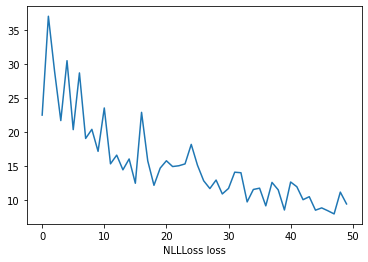

In [11]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.xlabel('NLLLoss loss')
torch.save(soundLoc2D_class, "/content/IA_sound_localization/soundLoc2D_1.pt")

In [14]:
def test(model):
    
    model.train(False)

    errors_abs = np.linspace(0,180,180)
    errors_count = np.zeros(180)
    
    for i in range(20):
      test_set = generateBatch2D()
      input = test_set[0]
      labels_in = test_set[1]

      outputs = model(input)

      for i in range(BATCH_SIZE):
        max1 = torch.argmax(outputs[i]).cpu().numpy()
        target = labels_in[i].cpu().numpy()

        index = np.min([(target - max1)%180, (max1 - target)%180])
        errors_count[int(index)] += 1

    return [errors_abs, errors_count]


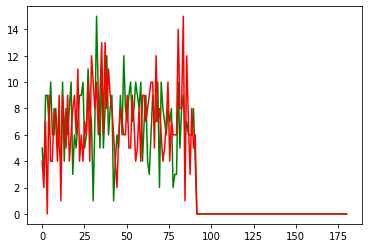

In [15]:
res1 = test(soundLoc2D_class.to(device_gpu))

untrained_network = soundLoc2D()
res2 = test(untrained_network.to(device_gpu))

plt.plot(res1[0], res1[1], color='green')
plt.plot(res2[0], res2[1], color='red')